## What stereotypes are associated with each video?

1. Prepare stereotypes.json and video-tags.json
2. Generate embeddings for stereotypes and video tags
3. Calculate similarity between video tags and stereotypes
4. Attribute stereotypes to videos
5. Visualise - plot heatmap, create network graph




In [20]:
import pandas as pd
import pickle

import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean
import seaborn as sns
import matplotlib.pyplot as plt


2024-10-16 16:49:21,120 - INFO - Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
2024-10-16 16:49:21,344 - INFO - generated new fontManager


In [14]:
# process original data
columns_to_read = [
    "url",
    "title",
    "categories",
    "date",
    "views",
    "upvotes",
    "downvotes",
    "production",
    "comments",
    "actors",
]

df = pd.read_csv(
    "data/raw/porn-with-dates-2022.csv", usecols=columns_to_read
)
df.head(5)

,url,title,categories,date,views,upvotes,downvotes,production,comments,actors
0,https://www.pornhub.com/view_video.php?viewkey...,Cute teen gloryhole handjob,"['Babe', 'Big Tits', 'Brunette', 'HD Porn', 'H...",2018-11-01,37012,78,22,professional,joesenetto 2 months ago In the name of the Rep...,NaN
1,https://www.pornhub.com/view_video.php?viewkey...,Realy Nice Step Mom Angie Gives Titjob Good Yo...,"['Blowjob', 'HD Porn', 'Hardcore', 'MILF', 'Ro...",2018-12-01,2083844,6318,174,professional,AStrayPornCritic 1 month ago Discussion- 2/10T...,NaN
2,https://www.pornhub.com/view_video.php?viewkey...,Step Mom´s gift for son - pov,"['Big Tits', 'Brunette', 'Cumshot', 'HD Porn',...",2018-07-01,22388562,64554,28325,professional,Leopold_Butters 6 months ago You ever had a mo...,"Alex Adams,Shay Evans"
3,https://www.pornhub.com/view_video.php?viewkey...,Baltimore Street Hooker Creampie,"['Amateur', 'Anal', 'Creampie', 'HD Porn', 'Ha...",2018-01-01,348440,1120,124,homemade,MusicSexBliss 1 year ago Nothing hotter that f...,NaN
4,https://www.pornhub.com/view_video.php?viewkey...,Cute Blonde and Brunette Pleasure Each Other,"['Amateur', 'Blonde', 'Brunette', 'Fingering',...",2018-12-01,105513,344,15,professional,deborahedwards947 3 weeks ago Want to see me s...,Alexis Brill


In [15]:
# Create 'tags' column from categories
df["tags"] = df["categories"].apply(clean.extract_tags)

# Remove a specific tag from the "tags" column
df["tags"] = df["tags"].apply(clean.remove_tag, tag_to_remove="HD Porn")

# confirm it is a list
# df.tags.apply(lambda tag_list: isinstance(tag_list, list))

In [17]:
# flatten out tags
df_flat_tag = clean.flatten_tags(df.tags)

# number of unique hashtags
df_flat_tag["tag"].unique().size

108

In [18]:
# count the number of each hashtag
popular_tags_set = clean.get_popular_tags(df_flat_tag)

# make a new column with only the popular tags
df["popular_tags"] = df.tags.apply(
    lambda tag_list: clean.filter_popular_tags(tag_list, popular_tags_set)
)

# drop rows without popular tag
df_popular_tags = df.loc[df.popular_tags.apply(lambda tag_list: tag_list != [])]

df_tags_vector = df_popular_tags.loc[:, ["popular_tags"]]

for tag in popular_tags_set:
    # make columns to encode presence of hashtags
    df_tags_vector["{}".format(tag)] = df_tags_vector.popular_tags.apply(
        lambda tag_list: int(tag in tag_list)
    )
# create a matrix of tags
tag_matrix = df_tags_vector.drop("popular_tags", axis=1)

In [19]:
tag_matrix.head(5)

,Lesbian,Blowjob,Toys,Brunette,Public,Anal,Fetish,Ebony,Babe,Hardcore,...,Reality,Threesome,Pornstar,Amateur,Masturbation,Teen,MILF,POV,Cumshot,Big Ass
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0


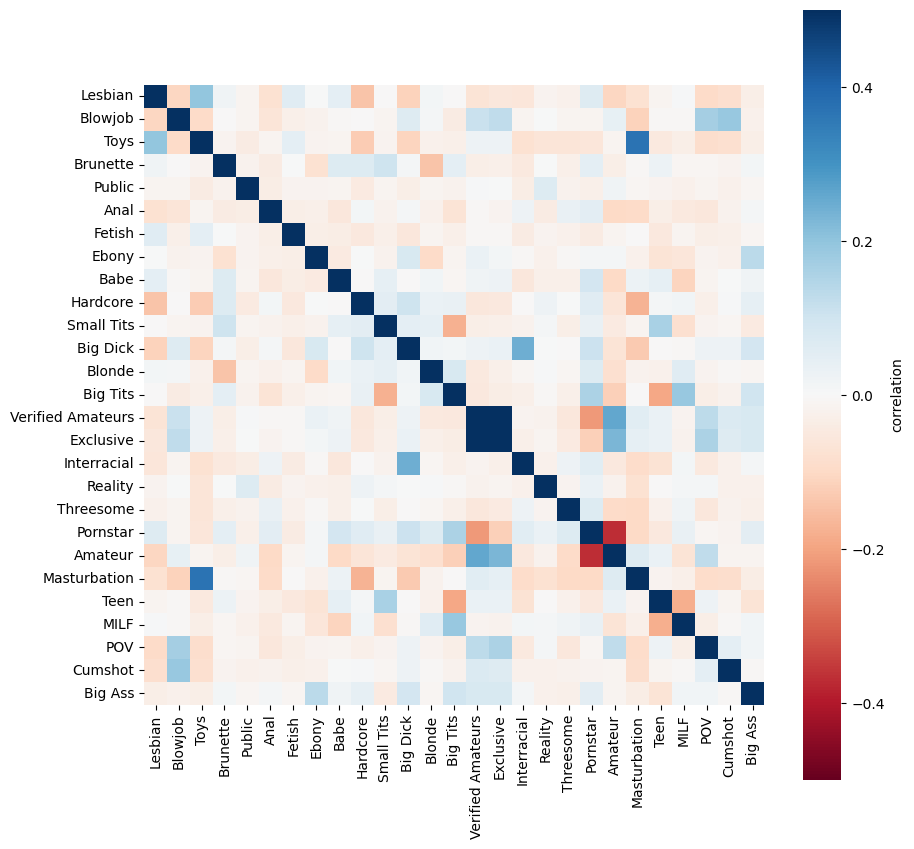

In [21]:
# plot the correlation matrix
correlations = tag_matrix.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    correlations,
    cmap="RdBu",
    vmin=-0.5,
    vmax=0.5,
    square=True,
    cbar_kws={"label": "correlation"},
)
plt.savefig("plots/tag_correlation.png")

In [ ]:
dat = pd.read_csv("data/processed/dat.csv")




In [ ]:
# extract video tags to create video-tags.json


In [ ]:
STEREOTYPES_JSON_PATH = "stereotypes.json"
TAGS_JSON_PATH = "video-tags.json"
dat = dat.head(10)

dat["popular_tags_formatted"] = dat["popular_tags"].apply(clean.extract_tags)
# prepare tags
helpers.df_to_json(
    df=dat, key_col_index=0, value_col_index=-1, filename="video-tags.json"
)

embeddings.download_nltk_data()
# load stereotypes
stereotypes = embeddings.load_and_preprocess_data(STEREOTYPES_JSON_PATH)
tags = embeddings.load_and_preprocess_data(TAGS_JSON_PATH)

stereotypes_emb = embeddings.generate_embeddings(stereotypes)
# TODO run for all and save results, long processing time
tags_emb = embeddings.generate_embeddings(tags)

# save tag embeddings
with open("tags_emb.pkl", "wb") as file:
    pickle.dump(tags_emb, file)

# # Load tags_emb from a file
# with open("tags_emb.pkl", "rb") as file:
#     tags_emb = pickle.load(file)

sim_df = embeddings.calculate_similarity(tags_emb, stereotypes_emb)

# TODO visualise sim df
# extract top 3 stereotypes for each video
# create df with extra column 'stereotype1', 'stereotype2', etc